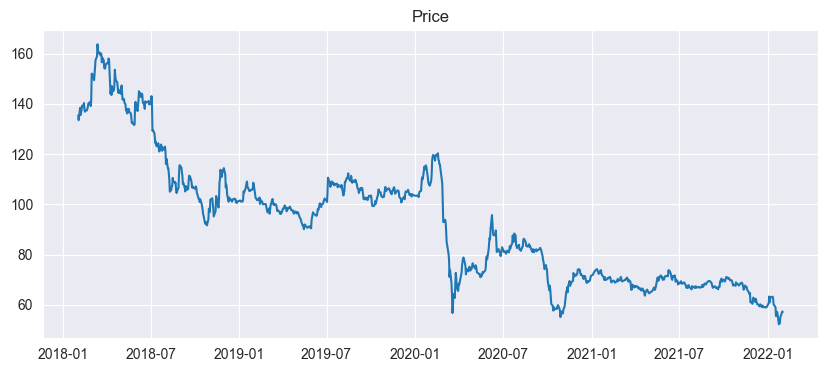

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller  # для ADF-теста
from arch import arch_model                      # для GARCH
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')   # Игнорирование некоторых предупреждений
%matplotlib inline

data = pd.read_csv('INPUT.csv')

# Преобразуем столбец Date в datetime и делаем его индексом
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Извлекаем временной ряд доходностей и удаляем пропуски
returns = data['Price'].dropna()

# Быстрый просмотр ряда
plt.figure(figsize=(10, 4))
plt.plot(returns.index, returns)
plt.title('Price')
plt.show()

In [2]:
adf_result = adfuller(returns, autolag='AIC')
adf_statistic = adf_result[0]
p_value = adf_result[1]
used_lag = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]

print("ADF Statistic: ", adf_statistic)
print("p-value: ", p_value)
print("Used lag: ", used_lag)
print("Number of observations used for the ADF regression and critical values calculation: ", n_obs)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}, {value}")

ADF Statistic:  -1.6062616106961916
p-value:  0.48044737193416837
Used lag:  4
Number of observations used for the ADF regression and critical values calculation:  1005
Critical Values:
    1%, -3.4368734638130847
    5%, -2.8644201518188126
    10%, -2.5683035273879358


In [3]:
if p_value < 0.05:
    print("Conclusion: The series is likely stationary (reject H0).")
else:
    print("Conclusion: The series is likely non-stationary (fail to reject H0).")

Conclusion: The series is likely non-stationary (fail to reject H0).


In [4]:
from itertools import product

# Possible values for p, q, r, s
p_values = [0, 1, 2]
q_values = [0, 1, 2]
r_values = [0, 1, 2]
s_values = [0, 1, 2]

best_aic = np.inf
best_params = None

for p, q, r, s in product(p_values, q_values, r_values, s_values):
    # Try fitting only if not all are zero, etc. (or you can just brute force everything)
    # We'll build a model using arch_model with mean='AR', lags=p, and order=(r, s).
    # 'vol='GARCH'' indicates a GARCH specification for the variance.
    # 'p' in arch_model corresponds to AR lags, 
    # 'q' in arch_model corresponds to the GARCH lag parameters, etc.

    # We pass 'lags=p' for an AR(p). If we also have a MA(q) part, in arch_model, 
    # you can do mean='ARX' and pass 'lags=[1,...,p]' plus an extra parameter for MA? 
    # Alternatively, we could do a separate ARIMA fit in statsmodels, then pass residuals to GARCH. 
    # But arch_model supports AR only (no direct built-in MA). 
    # For simplicity, let's assume we only do AR(p) for the mean and GARCH(r, s) for the variance 
    # due to arch_model constraints. If you truly need MA(q), consider combining with statsmodels.

    try:
        am = arch_model(
            returns,
            mean='AR',  # We'll approximate the ARIMA(p,d,q) with AR(p) only for demonstration
            lags=p,
            vol='GARCH',
            p=r,
            q=s,
            dist='normal'
        )
        res = am.fit(disp='off')
        this_aic = res.aic

        if this_aic < best_aic:
            best_aic = this_aic
            best_params = (p, 0, q, r, s)  # We used d=0 above
    except Exception as e:
        # Sometimes a model might fail to converge
        continue

print("Best AIC:", best_aic)
print("Best parameters (p,d,q,r,s):", best_params)

Best AIC: 3648.736119418997
Best parameters (p,d,q,r,s): (2, 0, 0, 1, 2)


In [5]:
final_p, final_d, final_q, final_r, final_s = best_params  # Or set them manually

final_model = arch_model(
    returns,
    mean='AR',
    lags=final_p,
    vol='GARCH',
    p=final_r,
    q=final_s,
    dist='normal'
)

final_result = final_model.fit(disp='off')
print(final_result.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  Price   R-squared:                       0.995
Mean Model:                        AR   Adj. R-squared:                  0.995
Vol Model:                      GARCH   Log-Likelihood:               -1817.37
Distribution:                  Normal   AIC:                           3648.74
Method:            Maximum Likelihood   BIC:                           3683.15
                                        No. Observations:                 1008
Date:                Mon, Dec 23 2024   Df Residuals:                     1005
Time:                        04:37:34   Df Model:                            3
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.2389      0.258      0.925      0.355    [ -

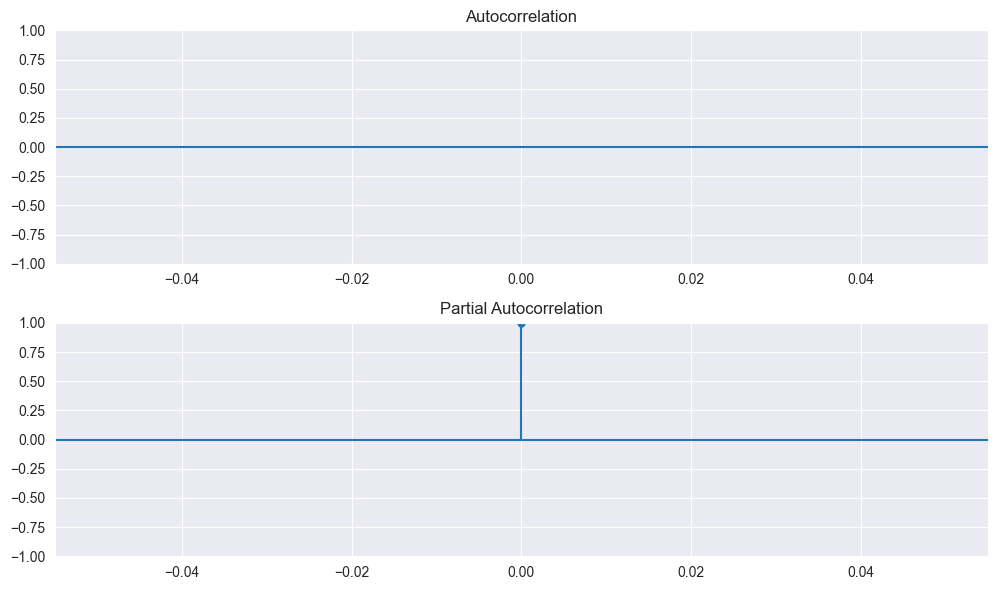

Ljung-Box test results for standardized residuals:
    lb_stat  lb_pvalue
10      NaN        NaN


In [6]:
residuals = final_result.resid   # raw residuals
# standardize them
std_residuals = final_result.std_resid

# Plot ACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(10,6))
sm.graphics.tsa.plot_acf(std_residuals, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(std_residuals, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

# Optionally run a Ljung-Box test
lb_test = sm.stats.diagnostic.acorr_ljungbox(std_residuals, lags=[10], return_df=True)
print("Ljung-Box test results for standardized residuals:")
print(lb_test)

In [9]:
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Q-Q plot
sm.qqplot(std_residuals, line='s', dist=stats.norm, fit=True)
plt.title("Q-Q Plot of Standardized Residuals")
plt.show()

# 2) Гистограмма остатков
sns.histplot(std_residuals, kde=True)
plt.title("Histogram of Standardized Residuals")
plt.show()

ValueError: The data contains non-finite values.

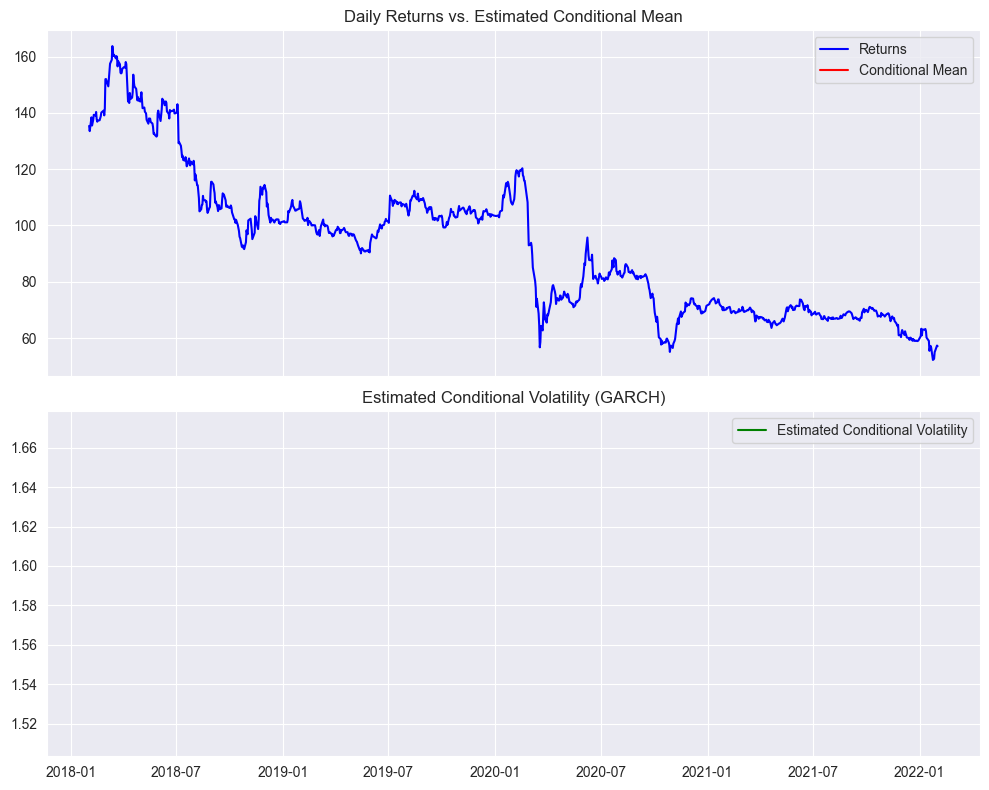

In [8]:
final_forecast = final_res.forecast()
cond_mean = final_forecast.mean['h.1']
cond_var = final_forecast.variance['h.1']
cond_std = np.sqrt(cond_var)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(returns.index, returns, label='Returns', color='blue')
ax[0].plot(cond_mean.index, cond_mean, label='Cond Mean', color='red')
ax[0].set_title('Daily Returns vs. Estimated Conditional Mean')
ax[0].legend()

ax[1].plot(cond_std.index, cond_std, label='Estimated Conditional Volatility', color='green')
ax[1].set_title('Estimated Conditional Volatility (GARCH)')
ax[1].legend()

plt.tight_layout()
plt.show()